In [124]:
import numpy as np
import matplotlib.pyplot as plt

# A computational replication of Cohn-Gordon and Bergen (2019)

## Some utilities

In [123]:
def normalize(arr, ax):
    return arr / arr.sum(axis=ax, keepdims=True)

def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats. 
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the 
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter, 
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

## The model in equations

These are the equations describing the model in Cohn-Gordon and Bergen:

\begin{align}
P_{\text{channel}}(w' \mid w, c) &= \frac{P(w' \mid c) \cdot \delta(w \neq w')}{\sum_{w''} P(w'' \mid c) \cdot \delta(w \neq w'')} \\
L_0(w \mid u, c) &\propto \|\mathbf{u}\|(w) \cdot P(w \mid c) \\
T_{S_1}(u, w, c) &= \ln(L_0(w \mid u, c)) \\
S_1(u \mid w, c) &\propto \exp(T_{S_1}(u, w, c)) \\
L_1^P(w \mid u, c) &\propto (P_{\text{prt}}(\text{True}) \cdot P(w \mid c) \cdot \sum_{w_{\text{pr}}} P_{\text{channel}}(w_{\text{pr}} \mid w) \cdot S_1(u \mid w_{\text{pr}}, c) ) + P_{\text{prt}}(\text{False}) \cdot P(w \mid c) \cdot S_1(u \mid w, c) \\
T_{S_2}(u, w, c) &= \ln(L_1^P(w \mid u, c)) \\
S_2(u \mid w, c) &\propto \exp(T_{S_2}(u, w, c)) \\
L_2(w, c \mid u) &\propto P_{\text{hyp}}(c) \cdot P(w \mid c) \cdot S_2(u \mid w, c) \\
T_{S_3}(u, w, c) &= \ln(L_2(w, c \mid u)) \\
S_3(u \mid w, c) &\propto \exp(T_{S_3}(u, w, c))
\end{align}

Where:
- $P_{\text{channel}}$ is the distribution over pretense worlds if a speaker decided to pretend to be in a different world. In this case it's sampled from the prior over world minus the actual world.
- $c$ parameterizes the listener's prior over $W$ (the world). In the simple case below, $P(w = T|c = r) = r$.
- See the paper for the meaning of the other symbols

## Model implementation

In [449]:
def run_model(p_prt, hyps, p_hyps):
    """
    Order of the values for various dimensions:
    - Utterance: [No, Yes]
    - States: [False, True]
    - Pretence values: [Pretend, Do not pretend]
    - c values: increasing probability of true state

    Parameters
    ----------
    p_prt: float
        The probability of pretending (to be in the other state)
    hyps: array[float]
        The possible common ground hypotheses considered by the L2
    p_hyps: array[float]
        The probability of each common ground hypothesis
    """
    
    # shape (c_value, state), encodes probability of each state given each c_value
    c_values = np.concatenate((1-hyps[:,None], hyps[:,None]),1)
    # (utterance, state)
    semantic = np.eye(2,2)

    # Encodes the probability of choosing a different state from the true one
    # which is just proportional to the state prior.
    # Dimensions (pretend state, c value, true state)
    p_channel = normalize( 
        (1-np.eye(2))[:,None,:]*c_values[None,:,:],
        (0)
    )

    # (c, utterance, state)
    l0 = normalize(
        c_values[:,None]*semantic,
        (2)
    )

    # (c value, utterance, state)
    t_s1 = np.log(l0)
    # (c value, utterance, state)
    s1 = softmax(t_s1, 1.0, axis=1)

    # (c value, utterance, state)
    l1 = normalize(
            # Interior of sum has shape (pretend state, c value, utterance, true state)
            # Note that the "state" value of s1 is moves to the first position
            # because it is taken to be the *pretend* state
            p_prt*c_values[:,None,:]*(p_channel[:,:,None,:]*np.moveaxis(s1,0,1)[:,:,:,None]).sum(0)+
        (1-p_prt)*c_values[:,None,:]*s1,
        2
    )

    # (c value, utterance, state)
    t_s2 = np.log(l1)
    s2 = softmax(t_s2, 1.0, axis=1)

    # (c value, utterance, state)
    l2 = normalize(
        p_hyps[:,None,None]*c_values[:,None,:]*s2,
        (0,2)
    )

    # (c value, utterance, state)
    t_s3 = np.log(l2)
    s3 = softmax(t_s3, 1.0, axis=1)
    
    return l0, s1, l1, s2, l2, s3

## Toy case from the paper

Here are the parameters involved:

- $ W : \{T, F\} $
- $ U : \{\text{Yes}, \text{No}\} $
- $\text{Prior}_w : \{T : 0.8, F : 0.2\}$
- $P_{\text{prt}} : \{\text{pretense} = \text{True} : 0.1, \text{pretense} = \text{False} : 0.9\}$
- $\|\cdot\| = \{\langle\text{Yes}, T\rangle, \langle\text{No}, F\rangle\}$

Example of run and output:

In [448]:
p_prt = 0.1
# possible common grounds over which L2 has uncertainty
hyps = np.array([0.90, 0.99])
# L2's prior probability of each common ground
p_hyps = np.array([0.5, 0.5])

l0, s1, l1, s2, l2, s3 = run_model(p_prt, hyps, p_hyps)

/tmp/ipykernel_919/4210871677.py:39: RuntimeWarning: divide by zero encountered in log
  t_s1 = np.log(l0)


`semantic` is trivial because there are only two states, e.g.:
```
array([[1., 0.],
       [0., 1.]])
```

p_channel is also trivial e.g., `p_channel[:,1,1]=array([1., 0.])`.


`l0` is similarly trivial e.g., `l0[0,1]=l0[0,1]`, and same for `s1`.

### Figure 1

/tmp/ipykernel_919/2120696048.py:23: RuntimeWarning: divide by zero encountered in log
  t_s1 = np.log(l0)


[Text(0, 0, 'T'), Text(1, 0, 'F')]

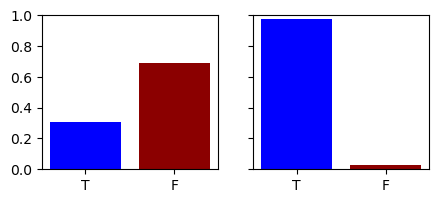

In [419]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(5,2))

hyps = np.array([0.80, 0.99])
p_hyps = np.array([0.5, 0.5])
l0, s1, l1, s2, l2, s3 = run_model(p_prt, hyps, p_hyps)

ax1.bar([1,0],l1[0,0], color=['darkred','blue'])
ax2.bar([1,0],l1[0,1], color=['darkred','blue'])

ax1.set_ylim(0,1)
ax1.set_xticks([0,1])
ax1.set_xticklabels(['T','F'])

### Figure 4

/tmp/ipykernel_919/2120696048.py:23: RuntimeWarning: divide by zero encountered in log
  t_s1 = np.log(l0)


<BarContainer object of 4 artists>

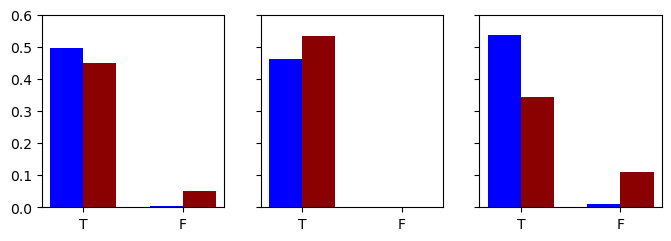

In [421]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,sharex=True, figsize=(8,2.5))

hyps = np.array([0.9, 0.99])
p_hyps = np.array([0.5, 0.5])
l0, s1, l1, s2, l2, s3 = run_model(p_prt, hyps, p_hyps)

x_values = [0.,0.2, 0.6,0.8]
color=['blue','darkred','blue','darkred']

ax1.set_ylim(0,0.6)
ax1.set_xticks([0.1, 0.7])
ax1.set_xticklabels(['T', 'F'])

ax1.bar(
    x_values,
    normalize(np.array([hyps[1], hyps[0], 1-hyps[1], 1-hyps[0]]),0),
    width=0.2,
    color=color
)

ax2.bar(
    x_values,
    [l2[1,1,1], l2[0,1,1], l2[1,1,0], l2[0,1,0]],
    width=0.2,
    color=color
)

ax3.bar(
    x_values,
    [l2[1,0,1], l2[0,0,1], l2[1,0,0], l2[0,0,0]],
    width=0.2,
    color=color
)


## Figure 5

In [434]:
hyps = np.linspace(0.001, 0.999, 10000)
p_hyps = np.ones_like(hyps) / len(hyps)
l0, s1, l1, s2, l2, s3 = run_model(p_prt, hyps, p_hyps)

/tmp/ipykernel_919/2120696048.py:23: RuntimeWarning: divide by zero encountered in log
  t_s1 = np.log(l0)


In [436]:
line_false, line_true = l2[:,0,:].T

> NOTE: Differently from the paper, we don't see the bimodality for the curve w=T. Where's the difference coming from?

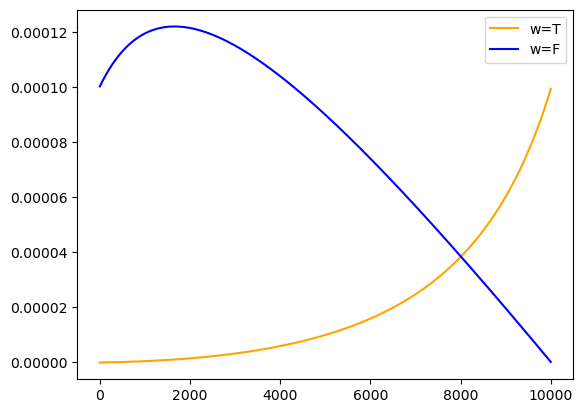

In [444]:
plt.plot(line_true, label='w=T', color='orange')
plt.plot(line_false, label='w=F', color='b')
plt.legend()